## Example 09 - Multiple vessels - edge constraints

### Imports
Import the required libraries

In [2]:
# package(s) related to time, space and id
import datetime
import platform
import random
import os

# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy

# spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# package(s) for data handling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# tranport network analysis package
import transport_network_analysis.core as core
import transport_network_analysis.graph_module as graph_module

# Used for mathematical functions
import math             

# Used for making the graph to visualize our problem
import networkx as nx 

### Create graph

The cel below visualizes the problem. In graph theory the red dots are called *edges* and the lines are called *vertices*. Vessels (or any other object) move from edge 1 to edge 3 and from edge 4 to edge 2. The added complexity is that vertice 5-6 only allows traffic in one direction at a time. Vessels can travel simultanously in one direction.

**Important**: 

If you use windows and get the following error "ImportError: read_shp requires OGR: http://www.gdal.org/", you probably have [this issue](https://github.com/conda-forge/gdal-feedstock/issues/219). Solving it is possible by running the following commands in your terminal (as explained [here](https://gis.stackexchange.com/questions/294231/installing-gdal-with-anaconda)):

```bash
#Create a new virtual environment
conda create -n testgdal -c conda-forge gdal vs2015_runtime=14

#Activate virtual environment
activate testgdal

#Open Jupyter notebook
jupyer notebook
```

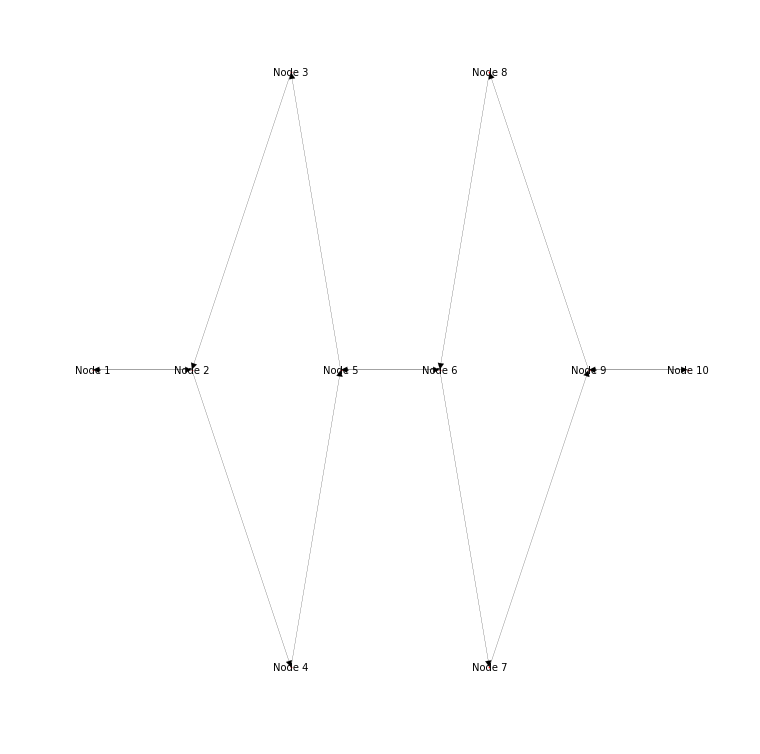

In [38]:
# Make networkx variable
graph = graph_module.Graph()
graph.graph = graph.graph.to_directed()

# Add graph nodes and edges
# Add nodes
node_1  = {"Name": "Node 1",  "Geometry": shapely.geometry.Point( 0.0, 2.5)}
node_2  = {"Name": "Node 2",  "Geometry": shapely.geometry.Point( 5.0, 2.5)}
node_3  = {"Name": "Node 3",  "Geometry": shapely.geometry.Point(10.0, 3.0)}
node_4  = {"Name": "Node 4",  "Geometry": shapely.geometry.Point(10.0, 2.0)}
node_5  = {"Name": "Node 5",  "Geometry": shapely.geometry.Point(12.5, 2.5)}
node_6  = {"Name": "Node 6",  "Geometry": shapely.geometry.Point(17.5, 2.5)}
node_7  = {"Name": "Node 7",  "Geometry": shapely.geometry.Point(20.0, 2.0)}
node_8  = {"Name": "Node 8",  "Geometry": shapely.geometry.Point(20.0, 3.0)}
node_9  = {"Name": "Node 9",  "Geometry": shapely.geometry.Point(25.0, 2.5)}
node_10 = {"Name": "Node 10", "Geometry": shapely.geometry.Point(30.0, 2.5)}

nodes = [node_1, node_2, node_3, node_4, node_5,
         node_6, node_7, node_8, node_9, node_10]

for node in nodes:
    graph.graph.add_node(node["Name"], 
                         geometry = node["Geometry"], 
                         Position = (node["Geometry"].x, node["Geometry"].y))

# Add edges
edge_1_2  = [ node_1,  node_2, "Canal"]
edge_2_1  = [ node_2,  node_1, "Canal"]

edge_3_2  = [ node_3,  node_2, "Canal"]
edge_5_3  = [ node_5,  node_3, "Canal"]

edge_2_4  = [ node_2,  node_4, "Waiting Area"]
edge_4_5  = [ node_4,  node_5, "Line-Up Area"]

edge_5_6  = [ node_5,  node_6, "Lock"]
edge_6_5  = [ node_6,  node_5, "Lock"]

edge_6_7  = [ node_6,  node_7, "Canal"]
edge_7_9  = [ node_7,  node_9, "Canal"]

edge_8_6  = [ node_8,  node_6, "Line-Up Area"]
edge_9_8  = [ node_9,  node_8, "Waiting Area"]

edge_9_10 = [ node_9, node_10, "Canal"]
edge_10_9 = [node_10,  node_9, "Canal"]

edges = [edge_1_2, edge_2_1,
         edge_3_2, edge_5_3,
         edge_2_4, edge_4_5,
         edge_5_6, edge_6_5,
         edge_6_7, edge_7_9,
         edge_8_6, edge_9_8,
         edge_9_10, edge_10_9]

for edge in edges:
    graph.graph.add_edge(edge[0]["Name"], edge[1]["Name"], Type = edge[2], weight = 1)
    
# Plot the graph
graph.plot(with_labels = True, font_size = 10, arrowsize = 15)

### Make vessels and paths

In [4]:
paths = []
random_1 = random.choice(list(graph.graph))
random_2 = random.choice(list(graph.graph))

path = nx.dijkstra_path(graph.graph, random_1, random_2)
paths.append(path)
paths.append(path)

path = nx.dijkstra_path(graph.graph, random_2, random_1)
paths.append(path)
paths.append(path)

In [5]:
# Make a class out of mix-ins
TransportResource = type('TransportResource', 
                         (core.Identifiable, core.Log, core.ContainerDependentMovable, 
                          core.HasResource, core.Routeable), {})



# For testing purposes we only want v to be 1
def compute_v_provider(v_empty, v_full):
    return lambda x: 1

data_vessel = {"env": None,
               "name": "Vessel",
               "route": None,
               "geometry": shapely.geometry.Point(0, 0),  # lon, lat
               "capacity": 1_000,
               "compute_v": compute_v_provider(v_empty=1, v_full=1)}

vessels = []
for i in range(4):
    vessel = TransportResource(**data_vessel)
    vessel.name = "Vessel " + str(i + 1)
    vessels.append(vessel)

### Start simulation

In [6]:
def start(env, vessel):
    while True:
        vessel.log_entry("Start sailing", env.now, "", vessel.geometry)
        yield from vessel.move()
        vessel.log_entry("Stop sailing", env.now, "", vessel.geometry)
        
        if vessel.geometry == nx.get_node_attributes(graph.graph, "Geometry")[vessel.route[-1]]:
            break

In [7]:
# Start simpy environment
env = simpy.Environment()

# Add graph to environment
graph.add_resources(list(graph.graph.edges), np.ones(len(list(graph.graph.edges))), env)
env.FG = graph.graph

for i, vessel in enumerate(vessels):
    # Add environment and path to the vessel
    vessel.env = env
    vessel.route = paths[i]
    vessel.geometry = nx.get_node_attributes(graph.graph, "Geometry")[paths[i][0]]

    # Add the movements of the vessel to the simulation
    env.process(start(env, vessel))

env.epoch = datetime.datetime.now()

env.run()

**** WAITING
**** WAITING
**** WAITING
**** WAITING
**** WAITING
**** WAITING
**** WAITING


### Obtain vessel log information
The cel below uses the vessel log. The core function *log_entry* is used, which takes four arguments:

- **Log.** A text to describe what is logged.
- **t.** The timestamp.
- **Value.**  The value for the log (for sailing this is the distance).
- **Geometry** The location of the vessel while loggin.

In [8]:
vessels[1].name

'Vessel 2'

In [9]:
vessel_log = pd.DataFrame.from_dict(vessels[0].log)
vessel_log.head()

,Message,Timestamp,Value,Geometry
0,Start sailing,0.000000,,POINT (4.2409164 51.3966421)
1,"Sailing from node (4.240916, 51.396642) to nod...",132.651003,132.651,POINT (4.2405519 51.3978124)
2,"Sailing from node (4.240552, 51.397812) to nod...",529.116472,396.465,POINT (4.2398223 51.4013466)
3,"Sailing from node (4.239822, 51.401347) to nod...",656.904430,127.788,POINT (4.2395723 51.4024845)
4,"Sailing from node (4.239572, 51.402484) to nod...",754.507261,97.6028,POINT (4.2393932 51.4033546)


In [10]:
vessel_log = pd.DataFrame.from_dict(vessels[1].log)
vessel_log.head()

,Message,Timestamp,Value,Geometry
0,Start sailing,0.000000,,POINT (4.2409164 51.3966421)
1,"Waiting to pass edge (4.240916, 51.396642) - (...",265.302006,0,POINT (4.2409164 51.3966421)
2,"Sailing from node (4.240916, 51.396642) to nod...",397.953009,132.651,POINT (4.2405519 51.3978124)
3,"Waiting to pass edge (4.240552, 51.397812) - (...",660.279935,0,POINT (4.2405519 51.3978124)
4,"Sailing from node (4.240552, 51.397812) to nod...",1056.745404,396.465,POINT (4.2398223 51.4013466)


### Visualization of path
If you get an error regarding ffmpeg use [this](https://stackoverflow.com/questions/13316397/matplotlib-animation-no-moviewriters-available) answer. You have to install ffmpeg in your Conda environment. It can be done using the following command.

```bash
#Install ffmpeg using Conda
conda install -c conda-forge ffmpeg
```

In [11]:
for vessel in vessels:
    geom_x = []
    geom_y = []

    for geom in vessel.log["Geometry"]:
        geom_x.append(geom.x)
        geom_y.append(geom.y)

    vessel.log["Geometry - x"] = geom_x
    vessel.log["Geometry - y"] = geom_y

In [12]:
time_stamp_min = []
time_stamp_max = []

for vessel in vessels:
    time_stamp_min.append(min(vessel.log["Timestamp"]))
    time_stamp_max.append(max(vessel.log["Timestamp"]))

time_stamp_min = min(time_stamp_min)
time_stamp_max = max(time_stamp_max)

stepsize = 60
steps = int(np.floor((time_stamp_max - time_stamp_min) / stepsize))

timestamps_t = np.linspace(time_stamp_min, time_stamp_max, steps)
for vessel in vessels:
    vessel.log["timestamps_x"] = np.interp(timestamps_t, vessel.log["Timestamp"], vessel.log["Geometry - x"])
    vessel.log["timestamps_y"] = np.interp(timestamps_t, vessel.log["Timestamp"], vessel.log["Geometry - y"])

In [13]:
# %%time

# # Make the animation
# fig = plt.figure(figsize = [12, 12])

# nx.draw(graph.graph, nx.get_node_attributes(graph.graph, 'Position'), 
#         with_labels = False, 
#         node_size = 0.5,
#         font_size = 2, 
#         width = 0.2, 
#         arrowsize = 3)


# location_1, = plt.plot([], [], color = "#1f77b4", marker = "o", markersize=15)
# path_1,     = plt.plot([], [], color = "#1f77b4")

# location_2, = plt.plot([], [], color = "#ff7f0e", marker = "o", markersize=15)
# path_2,     = plt.plot([], [], color = "#ff7f0e")

# location_3, = plt.plot([], [], color = "#2ca02c", marker = "o", markersize=15)
# path_3,     = plt.plot([], [], color = "#2ca02c")

# location_4, = plt.plot([], [], color = "#d62728", marker = "o", markersize=15)
# path_4,     = plt.plot([], [], color = "#d62728")

# location_5, = plt.plot([], [], color = "#9467bd", marker = "o", markersize=15)
# path_5,     = plt.plot([], [], color = "#9467bd")

# def init():
#     location_1.set_data([], [])
#     path_1.set_data([], [])
    
#     location_2.set_data([], [])
#     path_2.set_data([], [])
    
#     location_3.set_data([], [])
#     path_3.set_data([], [])
    
#     location_4.set_data([], [])
#     path_4.set_data([], [])
    
#     location_5.set_data([], [])
#     path_5.set_data([], [])

# def animate(i):
#     for j, vessel in enumerate(vessels):
#         this_x = [vessel.log["timestamps_x"][i]]
#         this_y = [vessel.log["timestamps_y"][i]]

#         past_x = [x for x in vessel.log["timestamps_x"][:i]]
#         past_y = [y for y in vessel.log["timestamps_y"][:i]]

#         if j == 0:
#             location_1.set_data(this_x, this_y)
#             path_1.set_data(past_x, past_y)
#         elif j == 1:
#             location_2.set_data(this_x, this_y)
#             path_2.set_data(past_x, past_y)
#         elif j == 2:
#             location_3.set_data(this_x, this_y)
#             path_3.set_data(past_x, past_y)
#         elif j == 3:
#             location_4.set_data(this_x, this_y)
#             path_4.set_data(past_x, past_y)
#         elif j == 4:
#             location_5.set_data(this_x, this_y)
#             path_5.set_data(past_x, past_y)

#     return location_1, location_2, location_3, location_4, location_5, path_1, path_2, path_3, path_4, path_5
    
        
# ani = animation.FuncAnimation(fig, animate, np.arange(0, len(timestamps_t)), init_func=init)
# ani.save('route - improved - example 08.mp4', fps=5)

In [14]:
# NB: this kml can still significantly be finetuned

# define an icon to use for the locations
icon = 'http://maps.google.com/mapfiles/kml/shapes/donut.png'
size = 1

# create a kml file containing the visualisation
kml = Kml()
fol = kml.newfolder(name="Dike Installation")

shared_style = Style()
shared_style.labelstyle.color = 'ffffffff'  # White
shared_style.labelstyle.scale = 1  
shared_style.iconstyle.color = 'ffff0000'  # Blue
shared_style.iconstyle.scale = 1
shared_style.iconstyle.icon.href = icon

# each stock should just be represented as a single point
for vessel in vessels:
    for log_index, value in enumerate(vessel.log["Geometry"][:-1]):
        
        begin = env.epoch + datetime.timedelta(seconds=vessel.log["Timestamp"][log_index])
        end = env.epoch + datetime.timedelta(seconds=vessel.log["Timestamp"][log_index + 1])
        pnt = fol.newpoint(name=vessel.name, coords=[(vessel.log["Geometry"][log_index].x, vessel.log["Geometry"][log_index].y)])
        pnt.timespan.begin = begin.isoformat()
        pnt.timespan.end = end.isoformat()
        pnt.style = shared_style

    begin = env.epoch + datetime.timedelta(seconds=vessel.log["Timestamp"][log_index + 1])
    end = env.epoch + datetime.timedelta(seconds=vessel.log["Timestamp"][log_index + 1])
    pnt = fol.newpoint(name=vessel.name, coords=[(vessel.log["Geometry"][log_index + 1].x, vessel.log["Geometry"][log_index + 1].y)])
    pnt.timespan.begin = begin.isoformat()
    pnt.timespan.end = end.isoformat()
    pnt.style = shared_style
        
kml.save("sharedstyle.kml")


In [15]:
# open the file
if platform.system():
    !start ./sharedstyle.kml
else:
    !start explorer ./sharedstyle.kml